### Applying model to training data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
%matplotlib inline

In [30]:
#specify data source 
datasource = 'LocusEnergy'

In [31]:
zipcode = '08641'

In [32]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis\PVreadingsStudies\main'
#we can choose which data to look at.
dataDir = mainDir + '/data/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [33]:
data = pd.read_csv(dataDir +'/training_data_2.csv')
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

dsummary = pd.read_csv(outputDir+"/fitsummary_2.csv")
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())
FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef_2.csv")

In [34]:
def DOY (timestamp): #Stand for "Day of Year"
    if (type(timestamp) is str):
        if len(timestamp) == 19:
            Date = datetime.datetime.strptime(timestamp,"%Y-%m-%d %H:%M:%S").date()
        if len(timestamp) == 10:
            Date = datetime.datetime.strptime(timestamp,"%Y-%m-%d").date()
    elif (type(timestamp) is datetime.date):
        Date = timestamp
    elif (type(timestamp) is pd.tslib.Timestamp):
        Date= timestamp.date()
    else:
        print 'not valid time object'
    y = str(Date.year)
    NewYear = datetime.datetime.strptime(y+'-01-01',"%Y-%m-%d").date()
    d = (Date - NewYear).days
    if (int(y)%4==0)&(Date > datetime.datetime.strptime(y+'-02-28',"%Y-%m-%d").date()): #leap year correction
        d = d-1
    return d;

def DBW (timestamp): #DBW ("Day Before Winter Solstice")
    d = DOY(timestamp)-355
    if d>0:
        d=d-365
    return d;

In [35]:
data['DBW'] = data.tsLocal.map(lambda x: DBW(x))
data['mpower'] = 0

In [36]:
knots = [-10./12, -8./12, -4./12, 0, 4./12, 8./12, 10./12]
x = data.s
yy = patsy.dmatrix("bs(x, knots = knots, degree=3, include_intercept=True,lower_bound=-1, upper_bound=1) - 1", {"x": x})
#remove last basis (non-zero at endpoint)
#y = np.delete(y,-1,1)
X = yy

for i in range(0,data.shape[0]):
    beta = FullModelCoef[['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9','c10']][FullModelCoef.DBW == data.DBW.iloc[i]]
    #beta = dsummary[['c1_predict','c2_predict','c3_predict','c4_predict','c5_predict','c6_predict','c7_predict','c8_predict',\
    #                 'c9_predict']][dsummary.DateNum == data.DateNum.iloc[i]]
    data.mpower.iloc[i] = np.dot(X[i,:],np.asarray(beta).T)

Write down predicted power in data file.

In [37]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower
0,2013-01-01 07:30:00,1.11014,-301.362934,NaN,2,25.887276,-0.999743,-355,0.161032


In [38]:
data.to_csv(dataDir +'/training_data_fitted_2.csv',index=False)

In [39]:
dsummary['mE'] = 0
for i in range(0, dsummary.shape[0]): 
    DateOfInterest = dsummary.Date.iloc[i]
    df = data[data.tsLocal.map(lambda x: x.date()) == DateOfInterest]

    #calculate total maximum daily energy production unit in kWhr
    if df.shape[0]>0:
        mE = df['mpower'].sum(skipna=False)*15/60
        #mE = sum(df.mpower)*15/60
        dsummary.mE.iloc[i] = mE

In [40]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax,PeakCheck,FirstCheck,SecondCheck,mE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01,-355,NaN,False,False,False,4.949771


In [41]:
dsummary.to_csv(outputDir +"/fitsummary_2.csv",index=False)

Now consider predicted maximum daily energy production versus real production.

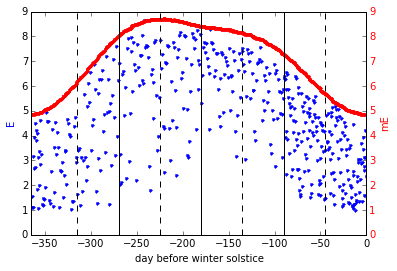

In [42]:
fig, ax1 = plt.subplots()
ax1.plot(dsummary.DBW, dsummary.E, 'b.')
ax1.set_xlabel('day before winter solstice')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E', color='b')
ax1.set_ylim(0,9)
    
ax2 = ax1.twinx()
ax2.plot(dsummary.DBW, dsummary.mE, 'r.')
ax2.set_ylabel('mE', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
   
for i in [-90,-180,-270]:
    ax2.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    ax2.axvline(x=i, color='black',linestyle='--')
ax2.set_xlim(-365,0)
ax2.set_ylim(0,9)
 
plt.savefig(outputDir +'/modelpredict.png')

Here we generate plots of normalized power generation and ideal power envelope on top. We also plots of ratio between actual generation and ideal generation. We add 0.01 on both numerator and denominator in calculation to avoid extreme values. 

In [43]:
directory = outputDir + '/dailyfit/'
if not os.path.exists(directory):
    os.makedirs(directory)
for i in range(0, dsummary.shape[0]): 
    DateOfInterest = dsummary.Date.iloc[i]
    E = dsummary.E.iloc[i]
    df = data[data.tsLocal.map(lambda x: x.date()) == DateOfInterest]

    x = df.s
    if (not math.isnan(E)):
        y = patsy.dmatrix("bs(x, knots = knots, degree=3, include_intercept=False,lower_bound=-1, upper_bound=1) - 1", {"x": x})
        #remove last basis (non-zero at endpoint)
        y = np.delete(y,-1,1)

        X = y
        y = df.power

        #add zero for nan
        y[map(math.isnan,y)] = 0

        beta = scipy.optimize.nnls(X,y)[0]
        dsummary.iloc[i,2:11] = beta
        ypredict = np.dot(X,beta)

        confidence = 0.95
        sigmasquare = np.dot(np.dot(X,beta)-y,np.dot(X,beta)-y)/(len(y)-9-1)
        kappa = sp.stats.t._ppf((1+confidence)/2., len(y)-9-1)
        band = kappa*np.sqrt(np.diagonal(np.mat(X)*(np.linalg.inv(np.mat(X.transpose())*np.mat(X))*np.mat(X.transpose())))*sigmasquare)

        Rsq = 1 - np.std(y-ypredict)*np.std(y-ypredict)/(np.std(y)*np.std(y))
    '''
    plt.clf()
    fig = plt.figure(figsize=(8,4))
    ax1  = fig.add_subplot(121)
    if (not math.isnan(E)):
        ax1.plot(x, ypredict,color='black');
        ax1.plot(x, y, marker='+', ls='None')
        ax1.fill_between(x, ypredict- band, ypredict+ band, color='grey', alpha='0.5')
    ax1.plot(x, df.mpower)
    ax1.set_title('Date: '+ DateOfInterest.strftime("%Y-%m-%d") + ', E =' + "{:.3f}".format(float(E))) 
    ax1.set_xlim(-1,1)
    ax1.set_ylim(0,1.1)
    
    ax1  = fig.add_subplot(122)
    if (not math.isnan(E)):
        ax1.plot(x, (df.power+0.01)/(df.mpower+0.01),color='blue');
        ax1.set_title('Date: '+ DateOfInterest.strftime("%Y-%m-%d") + ', relE =' + "{:.3f}".format(float(E)/float(mE)))
    ax1.plot(x, [1.0]*len(x), color='red')
    ax1.set_xlim(-1,1)
    ax1.set_ylim(0,1.1)
    
    filename = DateOfInterest.strftime("%Y-%m-%d") +'.png'
    fig.savefig(directory+filename)
    
    #plt.show()
    '''

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finally, we have a model to predict maximum power output at any 15 minutes of the year. This information is useful to grid operator to do energy planning. It will be useful in finer power output interval prediction as well.